# loading data

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
import numpy as np
from ipywidgets import Output
from IPython.display import display, HTML


from src.code_processing import parse_code_string, generate_linter_messages

# Enable interactive backend
%matplotlib widget

figsize = (10, 7)
resolution = 300 # dpi
data_path = Path('data')
ipython_path = data_path / 'ipython_new'

In [2]:
## load ipython items
items = pd.read_csv(ipython_path / 'item.csv', sep=";", index_col=0)

# drop unused columns
items = items[['name', 'instructions', 'solution', 'democode']]
# extract user instructions
items["instructions"] = items["instructions"].apply(lambda x: eval(x)[0][1])
# extract and decode example solutions
items["solution"] = items["solution"].apply(lambda x: eval(x)[0][1]).apply(parse_code_string)
items["democode"] = items["democode"].apply(lambda x: eval(x)[0][1]).apply(parse_code_string)

In [3]:
## load the ipython log
log = pd.read_csv(ipython_path / 'log.csv', sep=";")

# drop unused columns
log = log[["id", "user", "item", "answer", "correct", "responseTime", "time"]]
# correct data types
log["time"] = pd.to_datetime(log["time"])
log["correct"] = log["correct"].astype(bool)
# drop problematic rows
log.dropna(inplace=True)
log.drop_duplicates(inplace=True)
# decode submissions
log["answer"] = log["answer"].apply(parse_code_string)
# only correct answers
log = log[log["correct"]]
# only one answer per session, first because EduLint might already be integrated
log = log.reset_index().groupby(["user", "item"], as_index=False).first().set_index("index")

In [4]:
# keep only items with at least 100 submission
items = items.loc[items.index.isin((log["item"].value_counts() > 100).index)]

# filter them out of the log also
log = log[log["item"].isin(items.index)]

In [5]:
## load the defect table
defects = pd.read_csv(data_path / 'defects.csv')

# drop unused columns
defects = defects[["defect name", "EduLint code", "defect type", "description", "code example", "code fix example", "severity", "id"]]
# drop defects not detected by EduLint
defects.dropna(subset=["EduLint code"], inplace=True)
# convert EduLint codes from string to tuple
defects["EduLint code"] = defects["EduLint code"].apply(lambda x: tuple(map(str.strip, x.split(","))))
# drop the "missing docstring" defect (not really appropriate in the context)
# drop the "mixed indentation" defect (it is exceptionally noisy - errors during logging, students copy-pasting, ...)
defects.drop([66, 4], axis=0, inplace=True)
# create a dictionary mapping EduLint codes to the index of the associated defect
code_to_defect_id = {val: idx for idx, val in defects['EduLint code'].explode().items()}

In [6]:
## load the EduLint messages corresponding to the entries in the ipython log
# open the message log
messages = pd.read_csv(ipython_path / 'message_log.csv', index_col=0, header=0)

# remove some of the messages associated with the "trailing whitespace" defect (they are likely logging errors)
messages = messages[~messages['message'].isin(['no newline at end of file', 'trailing whitespace'])]

# keep only the messages still in the ipython log
messages = messages[messages["log entry"].isin(log.index)]

# keep only messages with an associated defect
messages = messages[messages["defect"].isin(code_to_defect_id.keys())]

# use defect ids instead of message codes
messages["defect"] = messages["defect"].replace(code_to_defect_id).astype(int)

messages.reset_index(drop=True, inplace=True)

C:\Users\pnede\AppData\Local\Temp\ipykernel_20536\1784967134.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  messages["defect"] = messages["defect"].replace(code_to_defect_id).astype(int)


In [7]:
# vectorize defects
defect_log = pd.crosstab(messages["log entry"], messages["defect"]).reindex(log.index, fill_value=0)

# replace defect counts with presence
defect_log = (defect_log > 0).astype(int)

# keep only detected defects
defects = defects.loc[defects.index.isin(defect_log.columns)]

# exploratory analysis

## detected defects

In [9]:
counts = defect_log.sum(axis=0).sort_values(ascending=False)
percentages = counts / len(defect_log) * 100

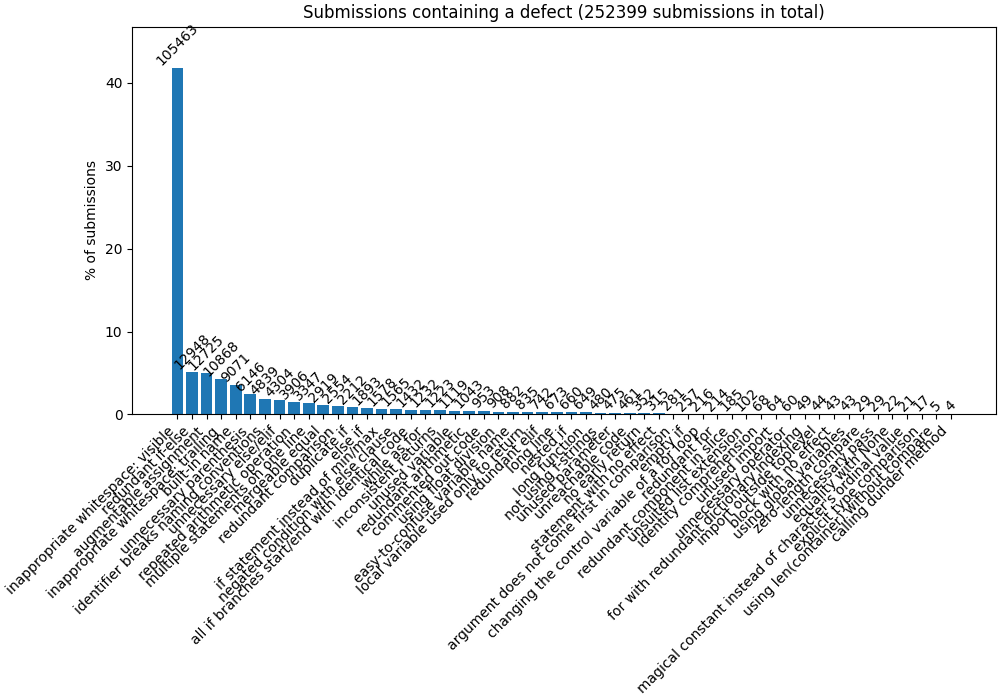

In [10]:
fig, ax = plt.subplots(layout="constrained", figsize=figsize)

p = ax.bar([defects['defect name'].loc[idx] for idx in counts.index], percentages)

ax.bar_label(p, labels = counts, label_type='edge', rotation=45)

ax.set_ylabel('% of submissions')
plt.xticks(rotation = 45, ha='right')
plt.ylim(0, max(percentages) + 5)
ax.set_title('Submissions containing a defect ({} submissions in total)'.format(len(defect_log)))

#plt.savefig('defect_histogram.png', dpi=300)
plt.show()

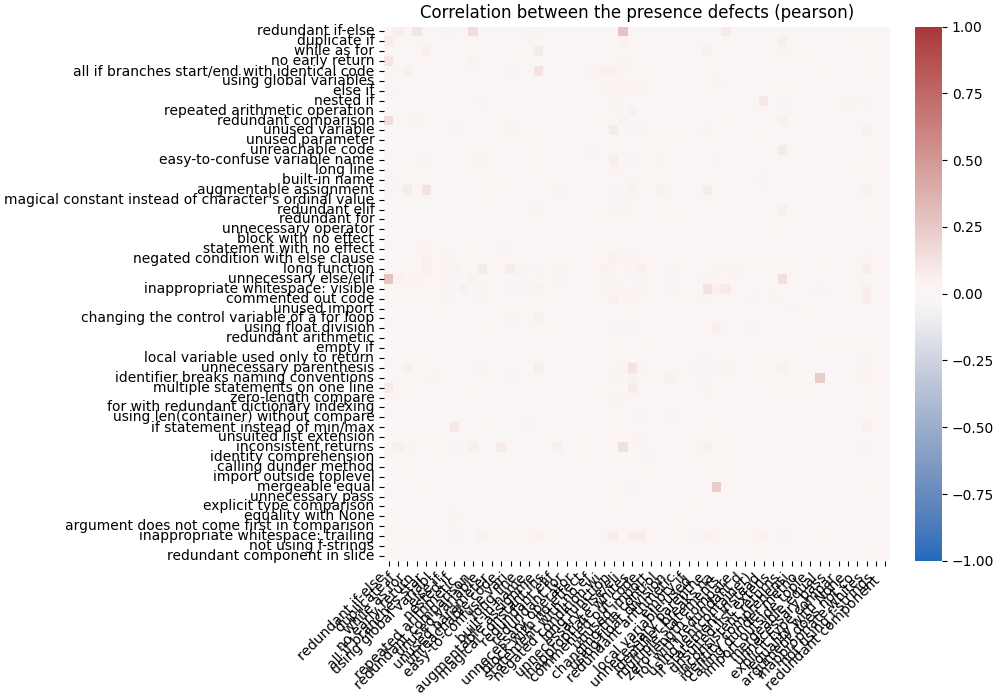

In [11]:
plt.figure(figsize=figsize, layout="constrained")
correlations = defect_log.corr().values
np.fill_diagonal(correlations, 0)
defect_names = defects['defect name'].loc[defect_log.columns]
sns.heatmap(correlations, xticklabels=defect_names.apply(lambda x: x[:20]), yticklabels=defect_names, vmin=-1, vmax=1, cmap="vlag")

plt.xticks(rotation = 45, ha='right')
plt.yticks(rotation = 0, ha='right')

plt.title('Correlation between the presence defects (pearson)'.format(len(defect_log)))
#plt.savefig('defect_correlation.png', dpi=300)
plt.show()

In [12]:
"""TODO
rare_codes = counts[counts < 100].index

counts = counts[counts >= 100]

percentages = counts / len(defect_log) * 100
fig, ax = plt.subplots(layout="constrained", figsize=figsize)

p = ax.bar(counts.index, percentages)

ax.bar_label(p, labels = counts, label_type='edge', rotation=45)

ax.set_ylabel('% of submissions')
plt.xticks(rotation = 45, ha='right')
plt.ylim(0, 40)
ax.set_title('EduLint codes without a corresponding defect (# of occurances < 100 omitted)'.format(len(defect_log)))

#plt.savefig('defect_histogram.png', dpi=300)
plt.show()
"""

'TODO\nrare_codes = counts[counts < 100].index\n\ncounts = counts[counts >= 100]\n\npercentages = counts / len(defect_log) * 100\nfig, ax = plt.subplots(layout="constrained", figsize=figsize)\n\np = ax.bar(counts.index, percentages)\n\nax.bar_label(p, labels = counts, label_type=\'edge\', rotation=45)\n\nax.set_ylabel(\'% of submissions\')\nplt.xticks(rotation = 45, ha=\'right\')\nplt.ylim(0, 40)\nax.set_title(\'EduLint codes without a corresponding defect (# of occurances < 100 omitted)\'.format(len(defect_log)))\n\n#plt.savefig(\'defect_histogram.png\', dpi=300)\nplt.show()\n'

## \# of defects histogram

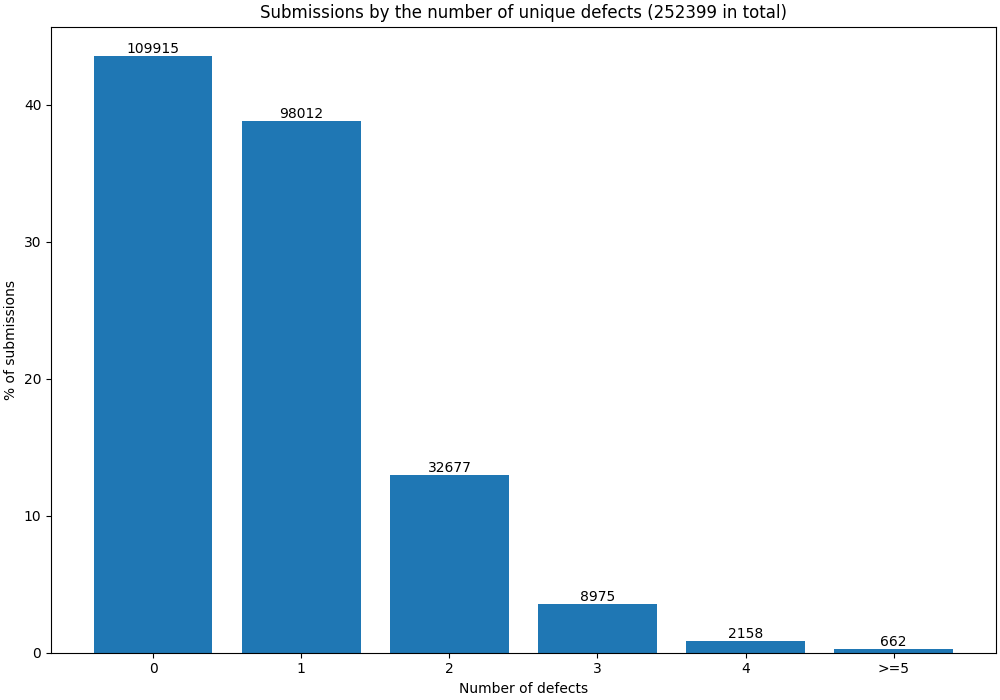

In [13]:
counts = defect_log.sum(axis=1).value_counts()

num_of_submissions = [str(i) for i in range(5)] + ['>=5']
defect_counts= list(counts[:5]) + [counts[5:].sum()]
defect_percentage = list(map(lambda x: x / len(defect_log) * 100, defect_counts))

fig, ax = plt.subplots(layout="constrained", figsize=figsize)

p = ax.bar(num_of_submissions, defect_percentage)

ax.bar_label(p, labels = defect_counts, label_type='edge')

ax.set_ylabel('% of submissions')
ax.set_xlabel('Number of defects')
ax.set_title('Submissions by the number of unique defects ({} in total)'.format(len(defect_log)))

#plt.savefig('submissions_histogram.png', dpi=300)
plt.show()

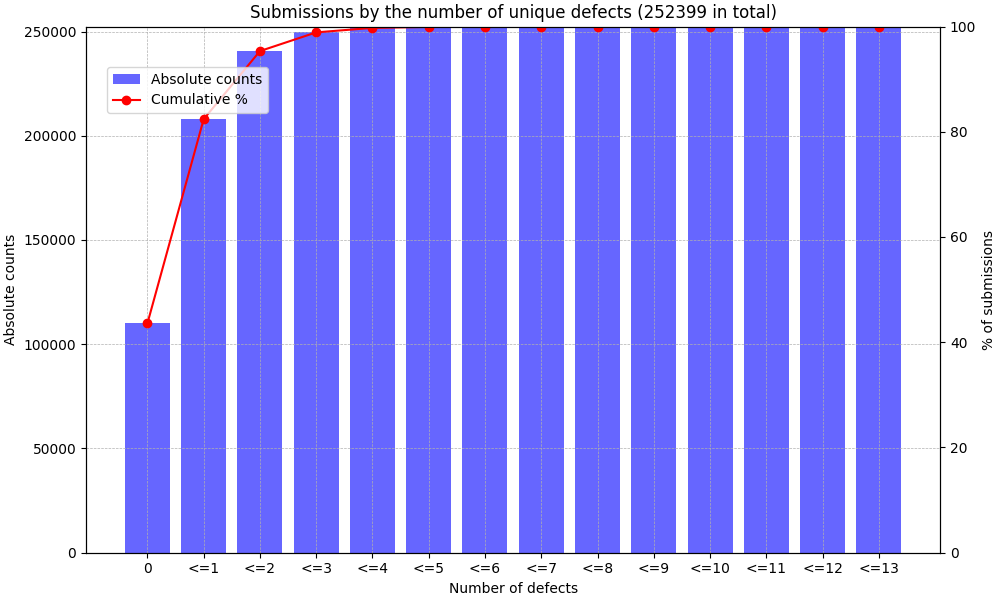

In [14]:
counts = defect_log.sum(axis=1).value_counts().cumsum()

num_of_submissions = ["0"] + [f"<={i}" for i in range(1, max(counts.index) + 1)]

max_idx = max(counts.index)
defect_counts = [
    counts.loc[idx] if idx in counts.index else counts.loc[max([j for j in counts.index if j < idx])]
    for idx in range(max_idx + 1)
]

defect_percentage = [(x / len(defect_log)) * 100 for x in defect_counts]

fig, ax1 = plt.subplots(layout="constrained", figsize=(10, 6))

bars = ax1.bar(num_of_submissions, defect_counts, alpha=0.6, color='blue', label='Absolute counts')

ax2 = ax1.twinx()
ax2.plot(num_of_submissions, defect_percentage, marker='o', color='red', label='Cumulative %')

ax1.set_ylabel('Absolute counts')
ax2.set_ylabel('% of submissions')
ax1.set_xlabel('Number of defects')
ax1.set_title(f'Submissions by the number of unique defects ({len(defect_log)} in total)')

ax1.set_ylim(0, len(defect_log))
ax2.set_ylim(0, 100)

ax1.grid(visible=True, linestyle='--', linewidth=0.5)
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

#plt.savefig('submissions_cumulative_histogram.png', dpi=300)
plt.show()

## severity

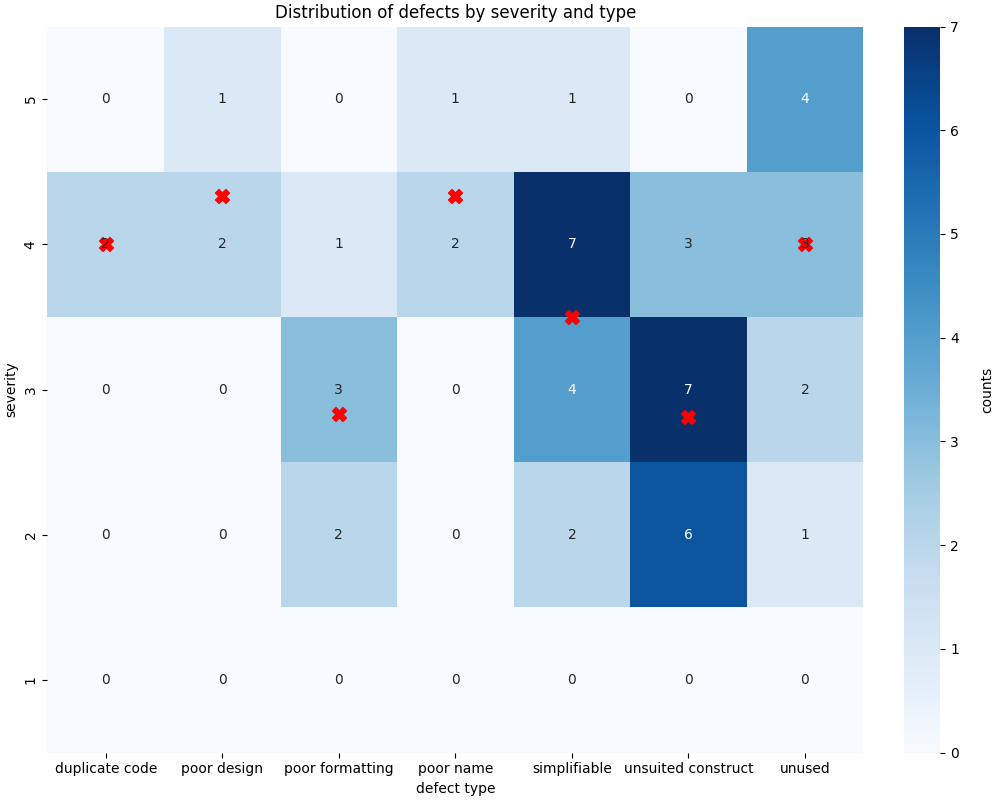

In [15]:
df = pd.crosstab(defects['severity'], defects['defect type'])
for i in range(1, 6):
    if i not in df.index:
        df.loc[i] = np.zeros(len(df.columns), dtype=int)
df.sort_index(inplace=True)

fig, ax = plt.subplots(figsize=(10, 8), layout="constrained")

sns.heatmap(df, annot=True, cmap="Blues", fmt="d", ax=ax)
for i, column in enumerate(df.columns):
    ax.scatter(i + 0.5, (df[column] * df.index).sum() / df[column].sum() - 0.5, marker='X', color='red', s=100)
ax.invert_yaxis()
colorbar = ax.collections[0].colorbar
colorbar.set_label('counts', rotation=90, labelpad=15)
plt.title('Distribution of defects by severity and type')
plt.show()

# defect co-occurance

## co-occurance matrix

In [16]:
# co-occurances
co_occurances = (defect_log.T.dot(defect_log)).values
np.fill_diagonal(co_occurances, 0)
defect_names = [defects['defect name'].loc[idx] for idx in defect_log.columns]

In [17]:
fig = px.imshow(co_occurances, x = defect_names, y = defect_names)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_layout(yaxis={"dtick":1},margin={"t":0,"b":0})
fig

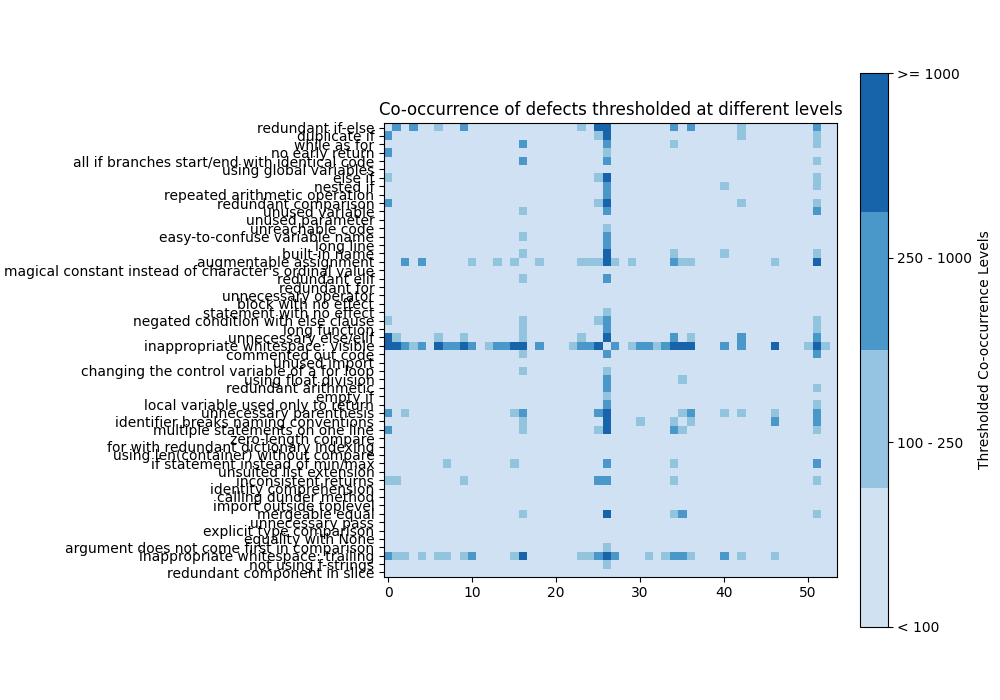

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Your data (assuming 'co_occurances' and 'defect_names' are defined elsewhere)
thresholded = co_occurances.copy()
thresholded[thresholded < 100] = 0
thresholded[thresholded >= 1000] = 3
thresholded[thresholded >= 250] = 2
thresholded[thresholded >= 100] = 1

cmap = ListedColormap(sns.color_palette("Blues", 4))

fig, ax = plt.subplots(figsize=figsize, layout="constrained")

p = ax.imshow(thresholded, cmap=cmap, vmin=0, vmax=3)

ax.set_yticks(np.arange(len(defect_names)))
ax.set_yticklabels(defect_names)

ax.set_title('Co-occurrence of defects thresholded at different levels')

cbar = fig.colorbar(p, ax=ax, ticks=[0, 1, 2, 3], shrink=0.8)
cbar.set_label('Thresholded Co-occurrence Levels')

cbar.set_ticks([0, 1, 2, 3])
cbar.set_ticklabels(['< 100', '100 - 250', '250 - 1000', '>= 1000'])

plt.show()


## by defect category

IndexError: index 6 is out of bounds for axis 0 with size 6

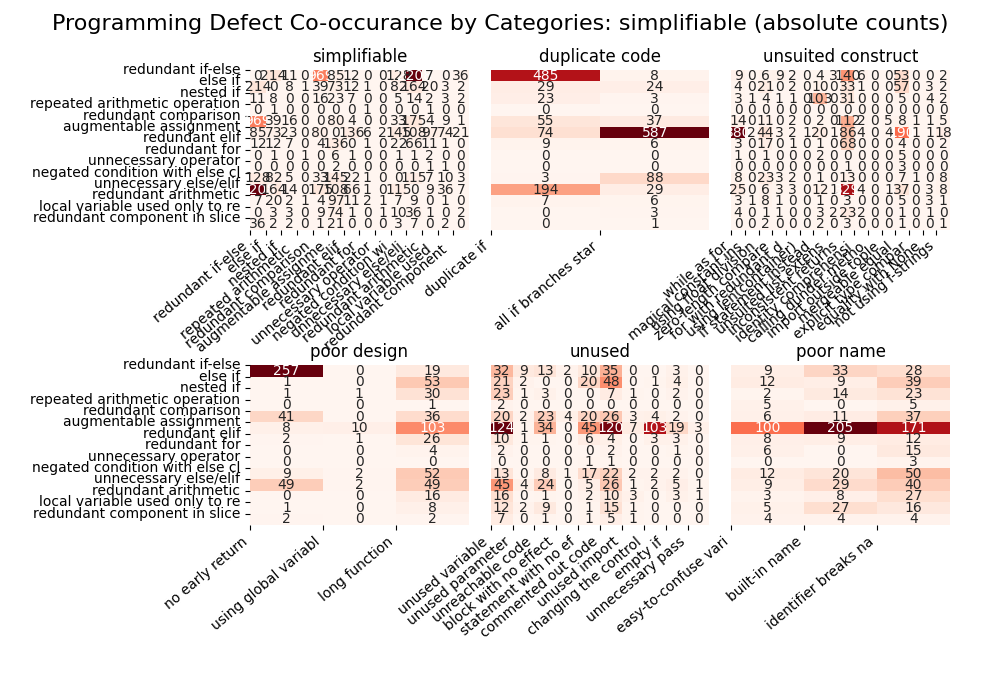

In [19]:
categories = defects['defect type'].loc[defect_log.columns]
dfs_by_category = {category: defect_log[columns].copy() for category, columns in categories.groupby(categories).groups.items()}
categories = categories.unique()
NUM_ROWS = 2
NUM_COLS = len(categories) // 2


for i in range(len(categories)):
    this_category = categories[i]
    fig, axes = plt.subplots(NUM_ROWS, NUM_COLS, figsize=figsize)
    fig.suptitle("Programming Defect Co-occurance by Categories: {} (absolute counts)".format(categories[i]), fontsize=16)
    axes = axes.flatten()
    for j in range(len(categories)):
        other_category = categories[j]
        this_df, other_df = dfs_by_category[this_category], dfs_by_category[other_category]
        
        product_df = this_df.T.dot(other_df)

        if this_category == other_category:
            np.fill_diagonal(product_df.values, 0)

        sns.heatmap(product_df, annot=True, cmap="Reds", fmt="d", ax=axes[j], cbar=False)
        axes[j].set_title(other_category)
        axes[j].set(xlabel="", ylabel="")
        axes[j].set_xticks(np.arange(product_df.shape[1]), labels=defects["defect name"].loc[product_df.columns].apply(lambda x: x[:20]), rotation=40, ha="right")
        if j % NUM_COLS == 0:
            axes[j].set_yticks(np.arange(product_df.shape[0]), labels=defects["defect name"].loc[product_df.index].apply(lambda x: x[:30]), rotation=0)
        else:
            axes[j].set_yticks([])
        
        plt.subplots_adjust(
            left=0.25,
            bottom=0.25, 
            right=0.95, 
            top=0.9, 
            wspace=0.1, 
            hspace=0.85
        )
                
        #plt.savefig('co_occurance_{}.png'.format(this_category), dpi=300)
    plt.show()

## by defect severity

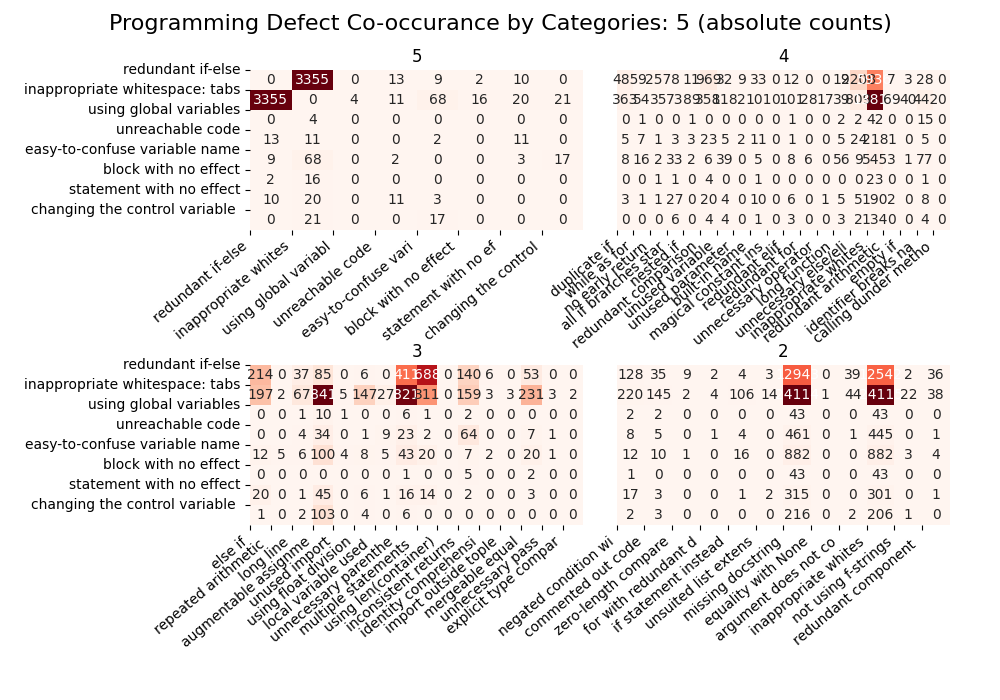

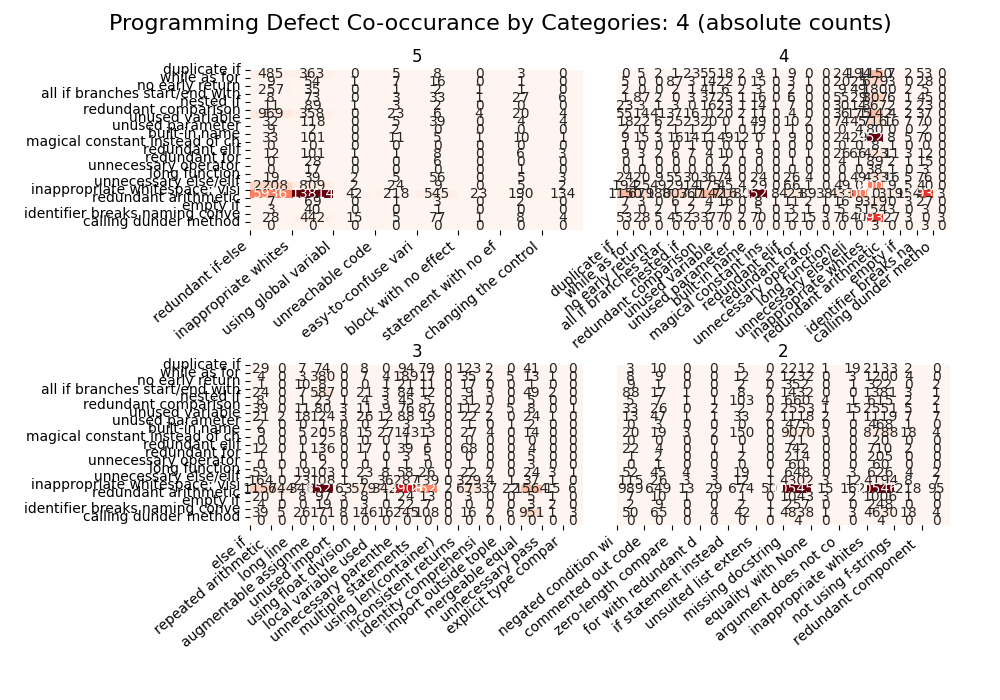

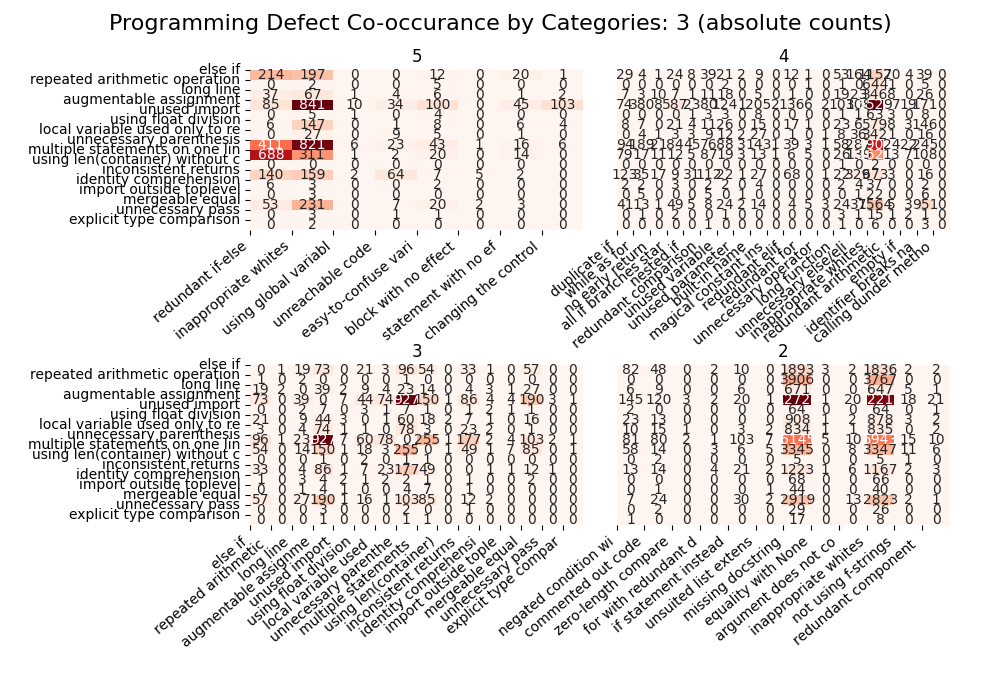

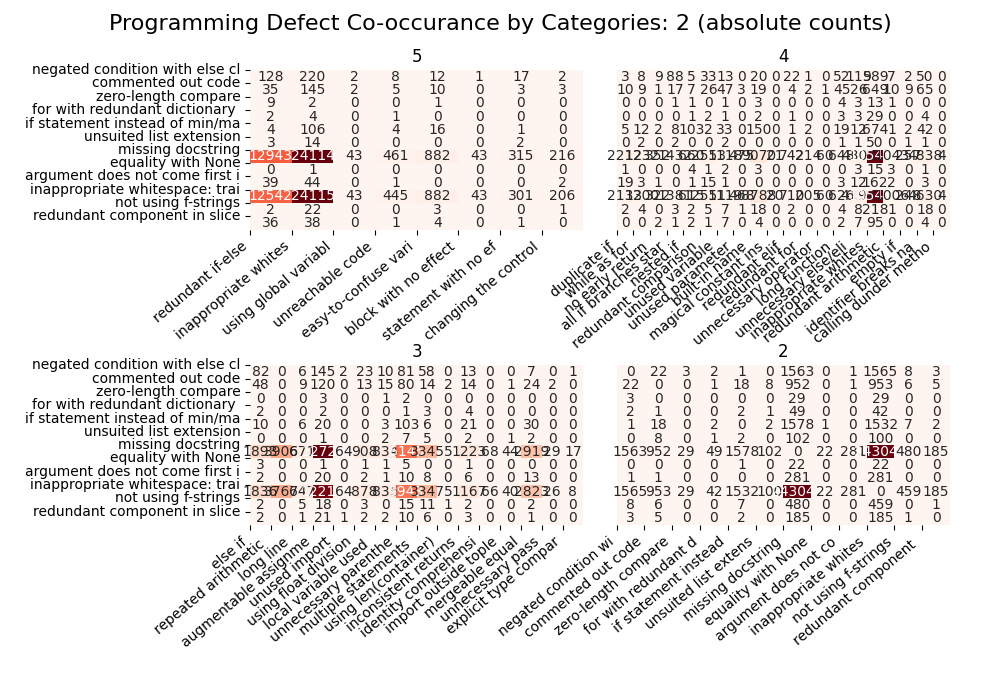

In [19]:
categories = defects['severity'].loc[defect_log.columns]
dfs_by_category = {category: defect_log[columns].copy() for category, columns in categories.groupby(categories).groups.items()}
categories = categories.unique()
NUM_ROWS = 2
NUM_COLS = len(categories) // 2


for i in range(len(categories)):
    this_category = categories[i]
    fig, axes = plt.subplots(NUM_ROWS, NUM_COLS, figsize=figsize)
    fig.suptitle("Programming Defect Co-occurance by Categories: {} (absolute counts)".format(categories[i]), fontsize=16)
    axes = axes.flatten()
    for j in range(len(categories)):
        other_category = categories[j]
        this_df, other_df = dfs_by_category[this_category], dfs_by_category[other_category]
        
        product_df = this_df.T.dot(other_df)

        if this_category == other_category:
            np.fill_diagonal(product_df.values, 0)

        sns.heatmap(product_df, annot=True, cmap="Reds", fmt="d", ax=axes[j], cbar=False)
        axes[j].set_title(other_category)
        axes[j].set(xlabel="", ylabel="")
        axes[j].set_xticks(np.arange(product_df.shape[1]), labels=defects["defect name"].loc[product_df.columns].apply(lambda x: x[:20]), rotation=40, ha="right")
        if j % NUM_COLS == 0:
            axes[j].set_yticks(np.arange(product_df.shape[0]), labels=defects["defect name"].loc[product_df.index].apply(lambda x: x[:30]), rotation=0)
        else:
            axes[j].set_yticks([])
        
        plt.subplots_adjust(
            left=0.25,
            bottom=0.25, 
            right=0.95, 
            top=0.9, 
            wspace=0.1, 
            hspace=0.85
        )
                
        #plt.savefig('co_occurance_{}.png'.format(this_category), dpi=300)
    plt.show()

# defects by tasks

## task-level defect anomalies

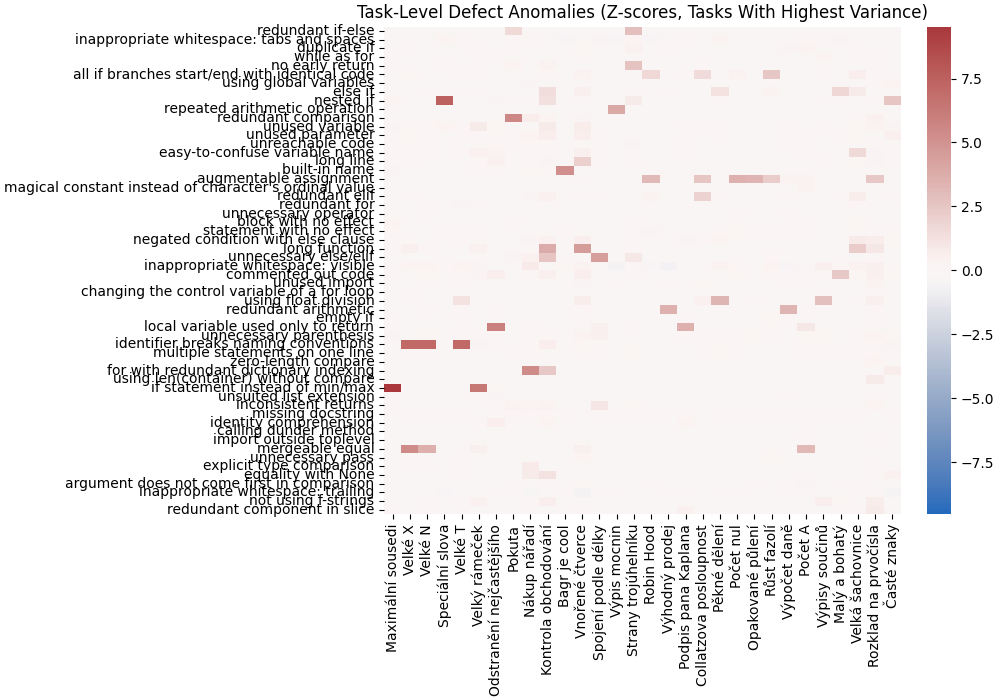

In [20]:
common_defects = (defect_log.groupby(log["item"]).mean() - defect_log.mean(axis=0)) / defect_log.std(axis=0)
highest_variance_tasks = common_defects.var(axis=1).sort_values(ascending=False)[:30].index
defect_names = [defects['defect name'].loc[idx] for idx in defect_log.columns]
task_names = [items['name'].loc[idx] for idx in highest_variance_tasks]

plt.figure(figsize=figsize, layout="constrained")
biggest_value = common_defects.abs().values.max()
sns.heatmap(common_defects.loc[highest_variance_tasks].T, xticklabels=task_names, yticklabels=defect_names, cmap="vlag", cbar=True, vmin=-biggest_value, vmax=biggest_value)
plt.title("Task-Level Defect Anomalies (Z-scores, Tasks With Highest Variance)")
plt.xlabel("")
plt.ylabel("")

# plt.savefig('defect_anomalies.png', dpi=300)
plt.show()

In [21]:
def task_and_defect_description(task, defect):  # noqa: D103
    task_row = items.loc[task]
    
    defect_row = defects.loc[defect]
    
    return f"""
    <div style="display: flex; justify-content: space-between; gap: 20px;">
        <!-- Task Section -->
        <div style="width: 48%; border: 1px solid #ccc; padding: 10px; border-radius: 5px;">
            <h3>{task_row["name"]}</h3>
            <div><strong>Instructions:</strong><br>{task_row["instructions"]}</div>
            <div><strong>Solution:</strong><br>
                <pre style="background-color: #2e2e2e; color: #f5f5f5; padding: 10px; border-radius: 5px; font-family: monospace;">{task_row["solution"]}</pre>
            </div>
        </div>
        
        <!-- Defect Section -->
        <div style="width: 48%; border: 1px solid #ccc; padding: 10px; border-radius: 5px;">
            <h3>{defect_row["defect name"]}</h3>
            <div><strong>Defect Type:</strong> {defect_row["defect type"]}</div>
            <div><strong>Severity:</strong> {defect_row["severity"]}</div>
            <div><strong>Description:</strong><br>{defect_row["description"]}</div>
            
            <div style="display: flex; justify-content: space-between; margin-top: 20px;">
                <div style="width: 48%; padding: 10px;">
                    <strong>Code Example:</strong><br>
                    <pre style="background-color: #2e2e2e; color: #f5f5f5; padding: 10px; border-radius: 5px; font-family: monospace;">{defect_row["code example"]}</pre>
                </div>
                <div style="width: 48%; padding: 10px;">
                    <strong>Code Fix Example:</strong><br>
                    <pre style="background-color: #2e2e2e; color: #f5f5f5; padding: 10px; border-radius: 5px; font-family: monospace;">{defect_row["code fix example"]}</pre>
                </div>
            </div>
        </div>
    </div>
    
    <!-- Code Snippet Section -->
    <div style="border: 1px solid #ccc; padding: 10px; margin-top: 20px; border-radius: 5px;">
        <strong>Example Submission:</strong><br>
        <pre style="background-color: #2e2e2e; color: #f5f5f5; padding: 10px; border-radius: 5px; font-family: monospace;">{log[(log["item"] == task) & (defect_log[defect])].iloc[0]["answer"]}</pre>
    </div>
    """

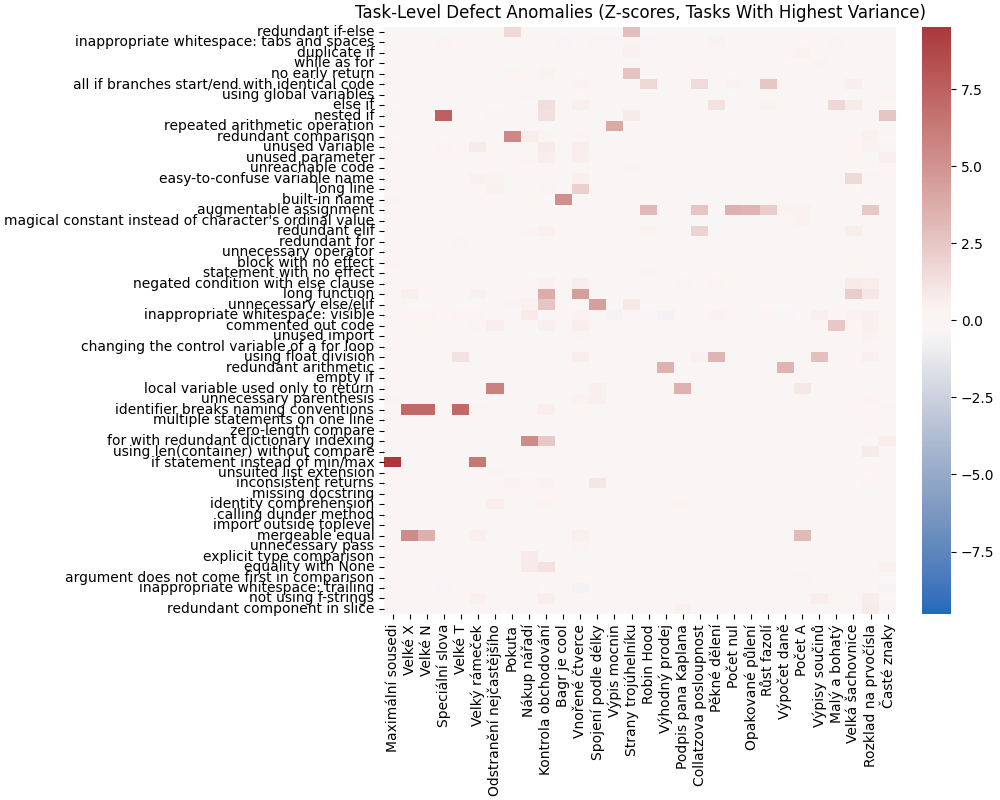

Output()

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import Output
from IPython.display import display, HTML

common_defects = (defect_log.groupby(log["item"]).mean() - defect_log.mean(axis=0)) / defect_log.std(axis=0)
highest_variance_tasks = common_defects.var(axis=1).sort_values(ascending=False)[:30].index
common_defects = common_defects.loc[highest_variance_tasks].T

fig, ax = plt.subplots(figsize=(10, 8), layout="constrained")
biggest_value = common_defects.abs().values.max() # for axis scale

sns.heatmap(
    common_defects,
    xticklabels=[items['name'].loc[idx] for idx in highest_variance_tasks],
    yticklabels=[defects['defect name'].loc[idx] for idx in defect_log.columns],
    cmap="vlag",
    cbar=True,
    vmin=-biggest_value,
    vmax=biggest_value,
    ax=ax
)
plt.title("Task-Level Defect Anomalies (Z-scores, Tasks With Highest Variance)")
plt.xlabel("")
plt.ylabel("")

# Create a dedicated output area for the click details
click_output = Output()

def on_click(event):  # noqa: D103
    if event.inaxes == ax:
        x, y = int(event.xdata), int(event.ydata)
        if 0 <= x < len(task_names) and 0 <= y < len(defect_names):
            task = highest_variance_tasks[x]
            defect = defect_log.columns[y]
            # value = common_defects.iloc[y, x]

            # Update the click output area
            with click_output:
                click_output.clear_output(wait=True)
                display(HTML(task_and_defect_description(task, defect)))

# Connect the click event
fig.canvas.mpl_connect('button_press_event', on_click)

# Show the heatmap and output
plt.show()
display(click_output)

## defects in task templates

In [23]:
democode_messages = items["democode"].apply(generate_linter_messages)
democode_messages = [
    {'item': idx, 'defect': code}
    for idx, code_message_list in democode_messages.items()
    for code, _ in code_message_list
]
democode_messages = pd.DataFrame(democode_messages)
democode_messages = democode_messages[democode_messages["defect"].isin(code_to_defect_id.keys())]
democode_messages["defect"] = democode_messages["defect"].replace(code_to_defect_id).astype(int)

C:\Users\pnede\AppData\Local\Temp\ipykernel_15704\2111781890.py:9: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [24]:
solution_messages = items["solution"].apply(generate_linter_messages)
solution_messages = [
    {'item': idx, 'defect': code}
    for idx, code_message_list in solution_messages.items()
    for code, _ in code_message_list
]
solution_messages = pd.DataFrame(solution_messages)
solution_messages = solution_messages[solution_messages["defect"].isin(code_to_defect_id.keys())]
solution_messages["defect"] = solution_messages["defect"].replace(code_to_defect_id).astype(int)

C:\Users\pnede\AppData\Local\Temp\ipykernel_15704\865104283.py:9: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



C:\Users\pnede\AppData\Local\Temp\ipykernel_15704\1986584540.py:3: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



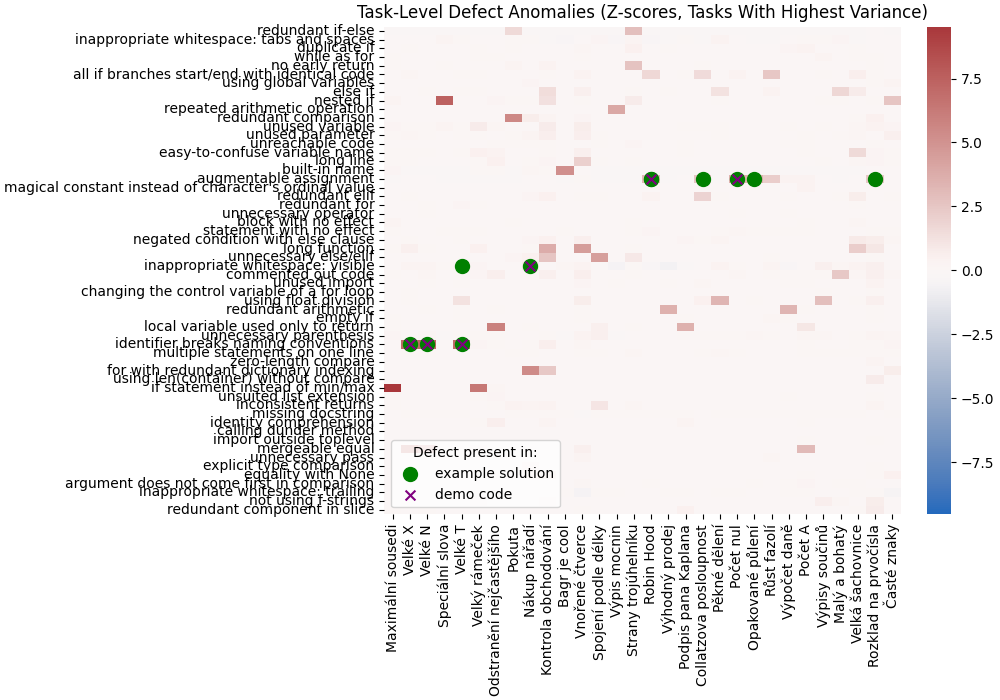

In [25]:
legend_markers = [plt.scatter([0], [0], color='green', s=100, marker='o'), plt.scatter([0], [0], color='purple', s=50, marker='x')]

plt.figure(figsize=figsize, layout="constrained")

biggest_value = common_defects.abs().values.max()

ax = sns.heatmap(
    common_defects,
    xticklabels=task_names,
    yticklabels=defect_names,
    cmap="vlag",
    cbar=True,
    vmin=-biggest_value,
    vmax=biggest_value
)

for _, row in solution_messages[solution_messages["item"].isin(highest_variance_tasks)].iterrows():
    x_pos = task_names.index(items['name'].loc[row['item']])
    y_pos = defect_names.index(defects['defect name'].loc[row['defect']])
    ax.scatter(x_pos + 0.5, y_pos + 0.5, color="green", s=100, marker='o')

for _, row in democode_messages[democode_messages["item"].isin(highest_variance_tasks)].iterrows():
    x_pos = task_names.index(items['name'].loc[row['item']])
    y_pos = defect_names.index(defects['defect name'].loc[row['defect']])
    ax.scatter(x_pos + 0.5, y_pos + 0.5, color="purple", s=50, marker='x')

plt.title("Task-Level Defect Anomalies (Z-scores, Tasks With Highest Variance)")
#plt.legend(title='Smoker', loc='upper left', labels=['Hell Yeh', 'Nah Bruh'])
plt.xlabel("")
plt.ylabel("")
plt.legend(legend_markers, ['example solution', 'demo code'], title='Defect present in:', loc='lower left')

#plt.savefig('defect_anomalies.png', dpi=300)
plt.show()

# defect severity

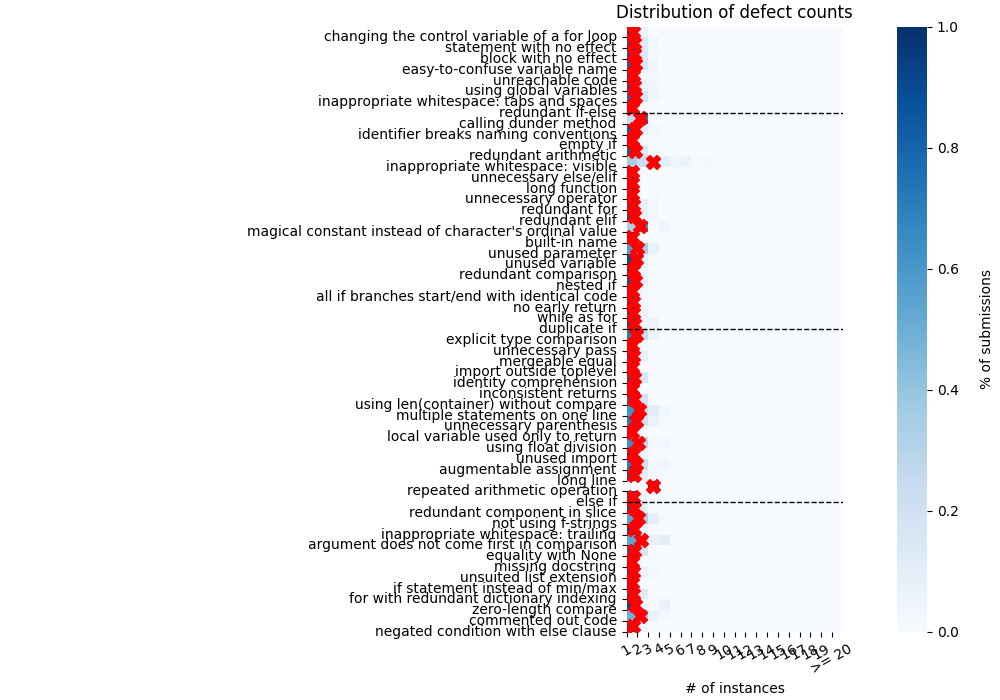

In [26]:
MAX_COUNT = 20
# use counts, not presence
defect_counts = pd.crosstab(messages["log entry"], messages["defect"])
# histogram for each defect
defect_counts = {col: defect_counts[col][defect_counts[col] > 0].value_counts() for col in defect_counts.columns}
# fill empty brackets with 0
defect_counts = pd.DataFrame(defect_counts).fillna(0).astype(int)
for i in range(1, MAX_COUNT):
    if i not in defect_counts.index:
        defect_counts.loc[i] = np.zeros(len(defect_counts.columns), dtype=int)
defect_counts.sort_index(inplace=True)
# sum the tail
defect_counts.loc[MAX_COUNT - 1] = defect_counts.iloc[MAX_COUNT:].sum(axis=0)
defect_counts = defect_counts.iloc[:MAX_COUNT]
# normalize the values
defect_counts = defect_counts.div(defect_counts.sum(axis=0), axis=1)

# order by severity
defect_counts = defect_counts[sorted(defect_counts.columns.tolist(), key=lambda x: defects["severity"].loc[x])]

# rotate
defect_counts = defect_counts.T

fig, ax = plt.subplots(figsize=figsize, layout="constrained")

sns.heatmap(defect_counts, cmap="Blues", fmt="d", ax=ax)
for i, row in enumerate(defect_counts.index):
    ax.scatter((defect_counts.loc[row] * defect_counts.columns.values).sum() / defect_counts.loc[row].sum() - 0.5, i + 0.5, marker='X', color='red', s=100)
ax.invert_yaxis()
ax.set_aspect('equal', 'box')

colorbar = ax.collections[0].colorbar
colorbar.set_label('% of submissions', rotation=90, labelpad=15)

plt.xticks(ticks=np.arange(MAX_COUNT), labels=[str(i) for i in range(1, MAX_COUNT)] + [f">= {MAX_COUNT}"], rotation=30)
plt.yticks(ticks=np.arange(len(defect_counts.index)), labels=[defects["defect name"].loc[row] for row in defect_counts.index], rotation=0)

severity = [defects["severity"].loc[row] for row in defect_counts.index]
for idx in range(1, len(severity)):
    if severity[idx] != severity[idx - 1]:
        plt.axhline(y=idx, color='black', linestyle='--', linewidth=1)

plt.xlabel("# of instances")
plt.title('Distribution of defect counts')
# plt.savefig('num_of_defects.png', dpi=300)
plt.show()

In [27]:
# SWITCH TO ALL SUBMISSIONS!

correlations = pd.DataFrame({
    task: defect_log[log['item'] == task].corrwith(log['correct'] - 1) for task in log['item'].unique()
})
counts = defect_log.groupby(log["item"]).sum().T
correlations = correlations[counts.columns]
correlations[counts < 100] = np.nan

highest_variance_tasks = correlations.var(axis=1).sort_values(ascending=False)[:30].index
defect_names = [defects['defect name'].loc[idx] for idx in defect_log.columns]
task_names = [items['name'].loc[idx] for idx in highest_variance_tasks]

plt.figure(figsize=figsize, layout="constrained")
sns.heatmap(common_defects.loc[highest_variance_tasks].T, xticklabels=task_names, yticklabels=defect_names, cmap="vlag", cbar=True, vmin=-1, vmax=1)
plt.title("Correlation between the presence defects and failure (pearson)")
plt.xlabel("")
plt.ylabel("")

# plt.savefig('success_correlations_across_tasks.png', dpi=300)
plt.show()

c:\Users\pnede\Desktop\git projects\umime-to-python-linter-analysis\.venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

c:\Users\pnede\Desktop\git projects\umime-to-python-linter-analysis\.venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning:

invalid value encountered in divide

c:\Users\pnede\Desktop\git projects\umime-to-python-linter-analysis\.venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

c:\Users\pnede\Desktop\git projects\umime-to-python-linter-analysis\.venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning:

invalid value encountered in divide

c:\Users\pnede\Desktop\git projects\umime-to-python-linter-analysis\.venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

c:\Users\pnede\Desktop\git projects\umime-to-python-linter-analysis\.venv\lib\site-packages\numpy\lib\fun

KeyError: 12

# Exploring specific defect co-occurances

In [28]:
def wrap_text(text, max_length=100):  # noqa: D103
    lines = []
    line = []
    length = 0

    for word in text.split():
        if (length := length + len(word) + 1) <= max_length:
            line.append(word)
        else:
            lines.append(" ".join(line))
            line = [word]
            length = len(word) + 1
    
    if line:
        lines.append(" ".join(line))
    
    return "\n".join(lines)


def item_info(idx):  # noqa: D103
    row = items.loc[idx]
    print('Task: ', row['name'])
    print('='*50)
    print('Description: ', wrap_text(row['instructions']), sep='\n')
    print('-'*50)
    print('Example solution: ', row['solution'], sep='\n')


def defect_info(idx):  # noqa: D103
    row = defects.loc[idx]
    print(row["defect type"], ": ", row['defect name'])
    print('='*50)
    print('Description: ', wrap_text(row['description']), sep='\n')
    print('-'*50)
    print('Code example: ', row['code example'], sep='\n')

In [29]:
defect1, defect2 = 29, 30
print(f"({defect1}, {defect2}) {defects.loc[defect1]['defect name']}, {defects.loc[defect2]['defect name']}")
defect_info(defect1)
print("\n\n")
defect_info(defect2)
df = log.loc[defect_log[(defect_log.loc[:, defect1] >= 1) & (defect_log.loc[:, defect2] >= 1)].index]
df["item"].value_counts()

KeyError: 29

In [ ]:
item = 60
item_df = df[df["item"] == item]
item_info(item)
print('-'*50)
for i in range(min(len(item_df), 5)):
    print(f"Solution {i + 1}, index: {item_df.index[i]}", item_df.iloc[i]["answer"], sep="\n")
    print("-"*50)

In [ ]:
index = 103332


In [ ]:
# defect descriptions
defect1_row = defects.loc[defect1, ["defect name", "description", "code example", "code fix example"]]
defect2_row = defects.loc[defect2, ["defect name", "description", "code example", "code fix example"]]
defect1_row.index = ["defect 1 name", "defect 1 description", "defect 1 code example", "defect 1 code fix example"]
defect2_row.index = ["defect 2 name", "defect 2 description", "defect 2 code example", "defect 2 code fix example"]

# item description
item_row = items.loc[item, ["name", "instructions"]]
item_row.index = ["item name", "item instructions"]

# user submission
log_row = log.loc[[index]].reset_index()[["index", "answer"]].iloc[0]
log_row.index = ["submission index", "submission text"]

new_row = pd.concat([item_row, log_row, defect1_row, defect2_row])
pd.concat([
    pd.read_csv(data_path / "questions.csv", sep=";", index_col=0),
    pd.DataFrame([new_row])
], ignore_index=True).to_csv(data_path / "questions.csv", sep=";")

In [ ]:
#pd.DataFrame([new_row]).to_csv("questions.csv", sep=";")